In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CarsFolderDataset(Dataset):
    """
    Dataset for folder-based structure where each folder is a class.
    
    Expected structure:
        root_dir/
            car1/
                image1.jpg
                image2.jpg
                ...
            car2/
                image1.jpg
                image2.jpg
                ...
    """
    def __init__(self, root_dir, transform=None, num_classes=20):
        self.root_dir = root_dir
        self.transform = transform
        self.num_classes = num_classes
        
        self.files = []
        self.labels = []
        
        # Get all class folders (sorted for consistency)
        all_class_folders = sorted([d for d in os.listdir(root_dir) 
                                    if os.path.isdir(os.path.join(root_dir, d))])
        
        # Take only first num_classes
        class_folders = all_class_folders[:num_classes]
        
        # Create class to index mapping
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_folders)}
        self.idx_to_class = {idx: cls_name for cls_name, idx in self.class_to_idx.items()}
        
        # Load all images
        for class_name in class_folders:
            class_path = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            # Get all image files in this class folder
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                # Check if it's a file (not a subdirectory)
                if os.path.isfile(img_path):
                    # Optional: filter by image extensions
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        self.files.append(img_path)
                        self.labels.append(class_idx)
        
        print(f"Loaded {len(self.files)} images from {len(class_folders)} classes.")
        print(f"Classes: {class_folders}")
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[idx]
        return img, label

In [2]:
class AugmentedDataset(Dataset):
    """
    Dataset wrapper that creates and saves augmented versions of images.
    Expands dataset by 4x: original + 3 augmentations per image.
    """
    def __init__(self, base_dataset, save_dir, augment_transform, transform=None):
        self.base = base_dataset
        self.save_dir = save_dir
        self.transform = transform
        self.augment_transform = augment_transform
        os.makedirs(self.save_dir, exist_ok=True)
        self.aug_paths = []
        self._prepare_augmented_images()
    
    def _prepare_augmented_images(self):
        print("Preparing augmented images...")
        for idx in range(len(self.base)):
            # Use the full file path and sanitize it for filename
            fname = self.base.files[idx].replace("/", "_").replace("\\", "_")
            orig_path = os.path.join(self.save_dir, f"{fname}_orig.jpg")
            aug_paths = [
                os.path.join(self.save_dir, f"{fname}_aug1.jpg"),
                os.path.join(self.save_dir, f"{fname}_aug2.jpg"),
                os.path.join(self.save_dir, f"{fname}_aug3.jpg"),
            ]
            
            # Only create if missing
            if not all(os.path.exists(p) for p in aug_paths):
                # Load original image
                img = Image.open(self.base.files[idx]).convert("RGB")
                
                # Save original
                if not os.path.exists(orig_path):
                    img.save(orig_path)
                
                # Create and save 3 augmentations
                for p in aug_paths:
                    aug_img = self.augment_transform(img)
                    aug_img.save(p)
            
            self.aug_paths.append([orig_path] + aug_paths)
        
        print(f"Augmented dataset ready: {len(self.aug_paths)} base images × 4 = {len(self)} total samples")
    
    def __len__(self):
        return len(self.base) * 4  # original + 3 augmentations
    
    def __getitem__(self, idx):
        base_idx = idx // 4
        aug_idx = idx % 4  # select which augmentation (0=orig, 1-3=augs)
        img_path = self.aug_paths[base_idx][aug_idx]
        label = self.base.labels[base_idx]
        
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [3]:
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
])
    
# Training transform (applied when loading)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

In [4]:
base_train_dataset = CarsFolderDataset(
    root_dir='/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train',
    transform=None  # No transform for base dataset
)

train_dataset = AugmentedDataset(
    base_dataset=base_train_dataset,
    save_dir='augmented_train',
    augment_transform=augment_transform,
    transform=train_transform
)
# Test dataset WITHOUT augmentation
test_dataset = CarsFolderDataset(
    root_dir='/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test',
    transform=test_transform
)


Loaded 819 images from 20 classes.
Classes: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012']
Preparing augmented images...
Augmented dataset ready: 819 base images × 4 = 3276 total samples
Loaded 811 images from 20 classes.
Classes: ['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 

In [5]:
import numpy as np
from torch.utils.data import WeightedRandomSampler
train_labels = train_dataset.base.labels * 4  # Each label appears 4 times due to augmentation
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = [class_weights[label] for label in train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print("Class counts:", class_counts)
print("Class weights:", class_weights)
    
    # Create dataloaders (use sampler for train, shuffle for test)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Class counts: [180 180 128 172 168 164 156 180 164 132 152 164 172 164 172 148 180 160
 168 172]
Class weights: [0.00555556 0.00555556 0.0078125  0.00581395 0.00595238 0.00609756
 0.00641026 0.00555556 0.00609756 0.00757576 0.00657895 0.00609756
 0.00581395 0.00609756 0.00581395 0.00675676 0.00555556 0.00625
 0.00595238 0.00581395]


Total unique images: 819
Visualizing 2 sample images with their augmentations...
Saved visualization to: sample_augmentations.png


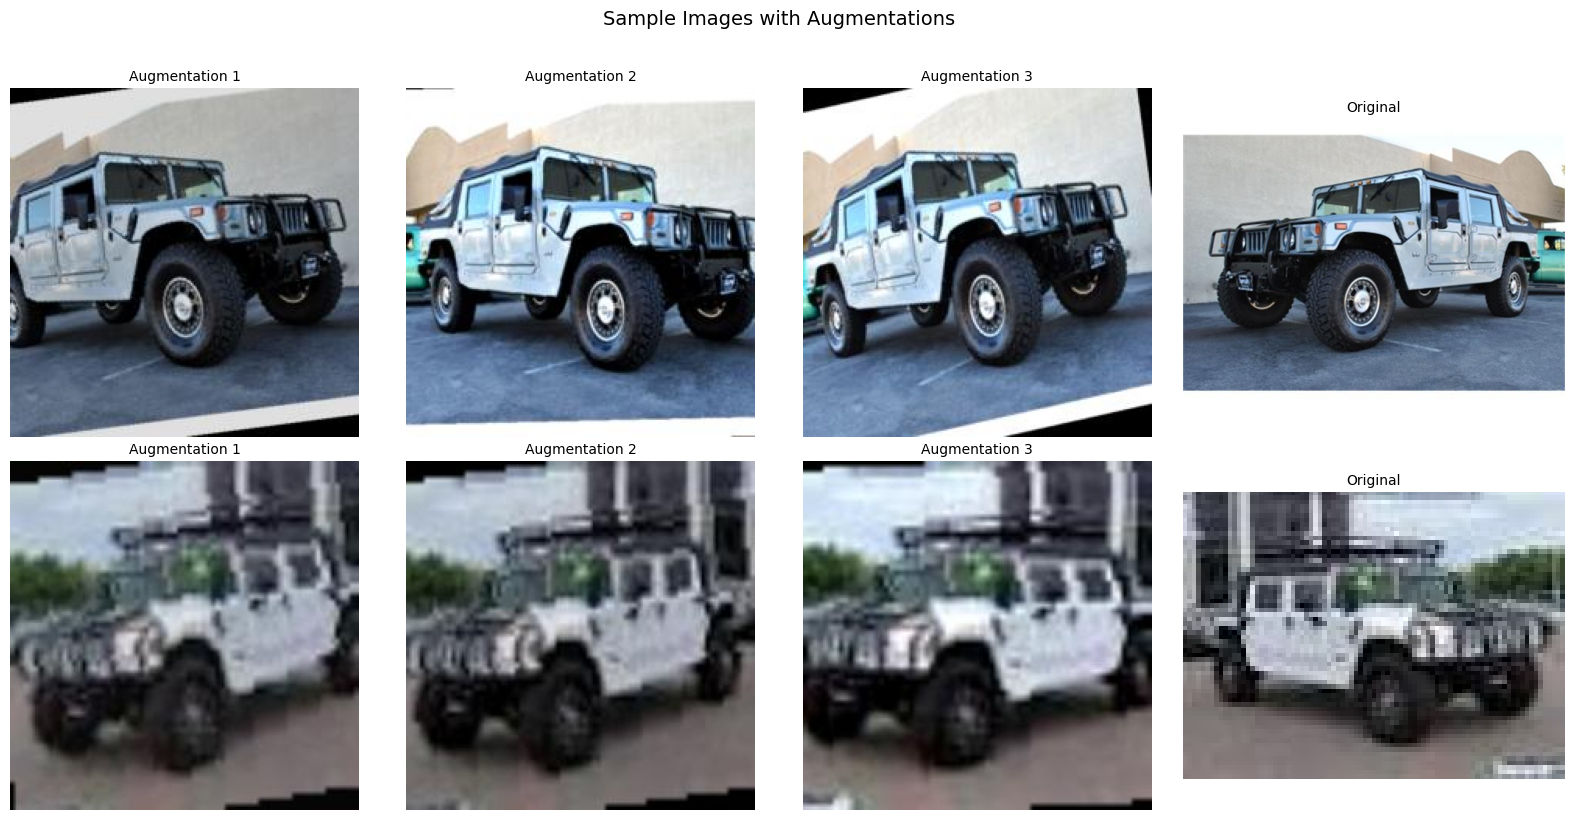

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Folder where augmentations were saved
aug_dir = "augmented_train"  # Change this to match your save_dir

# Get all files
all_files = sorted(os.listdir(aug_dir))

# Group them by base name
grouped = {}
for f in all_files:
    # Extract base name (everything before _orig/_aug1/_aug2/_aug3)
    if f.endswith('.jpg'):
        # Split by underscore and remove the last part (_orig.jpg, _aug1.jpg, etc.)
        parts = f.rsplit('_', 1)
        if len(parts) == 2:
            base = parts[0]  # Everything before the last underscore
            grouped.setdefault(base, []).append(f)

# Pick 2 sample images
sample_keys = list(grouped.keys())[:2]

print(f"Total unique images: {len(grouped)}")
print(f"Visualizing 2 sample images with their augmentations...")

# Create plot: 2 rows (images) × 4 columns (orig + 3 augs)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for row, key in enumerate(sample_keys):
    files = sorted(grouped[key])  # Should be: orig, aug1, aug2, aug3
    
    for col, fname in enumerate(files):
        img_path = os.path.join(aug_dir, fname)
        img = Image.open(img_path)
        axes[row, col].imshow(img)
        
        # Create cleaner title
        if 'orig' in fname:
            title = 'Original'
        elif 'aug1' in fname:
            title = 'Augmentation 1'
        elif 'aug2' in fname:
            title = 'Augmentation 2'
        elif 'aug3' in fname:
            title = 'Augmentation 3'
        else:
            title = fname
        
        axes[row, col].set_title(title, fontsize=10)
        axes[row, col].axis("off")

plt.suptitle('Sample Images with Augmentations', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("sample_augmentations.png", dpi=150, bbox_inches='tight')
print("Saved visualization to: sample_augmentations.png")
plt.show()
plt.close()

In [7]:
from collections import Counter
import numpy as np

print("="*60)
print("Dataset Label Distribution Check")
print("="*60)

# For AugmentedDataset (train_dataset)
print("\n--- Training Dataset (Augmented) ---")
# Get base labels (each appears 4 times due to augmentation)
train_base_labels = train_dataset.base.labels
train_all_labels = train_base_labels * 4  # Each label repeated 4 times

print(f"Total training samples: {len(train_dataset)}")
print(f"Unique base samples: {len(train_base_labels)}")
print(f"\nTrain class counts (with augmentations):")
train_counter = Counter(train_all_labels)
for class_idx in sorted(train_counter.keys()):
    class_name = train_dataset.base.idx_to_class[class_idx]
    print(f"  Class {class_idx} ({class_name}): {train_counter[class_idx]} samples")

# For regular CarsFolderDataset (test_dataset)
print("\n--- Test Dataset ---")
test_labels = test_dataset.labels

print(f"Total test samples: {len(test_dataset)}")
print(f"\nTest class counts:")
test_counter = Counter(test_labels)
for class_idx in sorted(test_counter.keys()):
    class_name = test_dataset.idx_to_class[class_idx]
    print(f"  Class {class_idx} ({class_name}): {test_counter[class_idx]} samples")

# Summary statistics
print("\n" + "="*60)
print("Summary Statistics")
print("="*60)
train_counts = np.array(list(train_counter.values()))
test_counts = np.array(list(test_counter.values()))

print(f"\nTraining set:")
print(f"  Min samples per class: {train_counts.min()}")
print(f"  Max samples per class: {train_counts.max()}")
print(f"  Mean samples per class: {train_counts.mean():.2f}")
print(f"  Std samples per class: {train_counts.std():.2f}")

print(f"\nTest set:")
print(f"  Min samples per class: {test_counts.min()}")
print(f"  Max samples per class: {test_counts.max()}")
print(f"  Mean samples per class: {test_counts.mean():.2f}")
print(f"  Std samples per class: {test_counts.std():.2f}")

# Check class balance
train_balance_ratio = train_counts.max() / train_counts.min()
test_balance_ratio = test_counts.max() / test_counts.min()

print(f"\nClass balance ratio (max/min):")
print(f"  Training: {train_balance_ratio:.2f}x")
print(f"  Test: {test_balance_ratio:.2f}x")

if train_balance_ratio > 2.0:
    print(f"\n⚠️  Training set is imbalanced (ratio > 2.0)")
    print(f"    Consider using WeightedRandomSampler!")
else:
    print(f"\n✓ Training set is reasonably balanced")

if test_balance_ratio > 2.0:
    print(f"⚠️  Test set is imbalanced (ratio > 2.0)")
else:
    print(f"✓ Test set is reasonably balanced")

Dataset Label Distribution Check

--- Training Dataset (Augmented) ---
Total training samples: 3276
Unique base samples: 819

Train class counts (with augmentations):
  Class 0 (AM General Hummer SUV 2000): 180 samples
  Class 1 (Acura Integra Type R 2001): 180 samples
  Class 2 (Acura RL Sedan 2012): 128 samples
  Class 3 (Acura TL Sedan 2012): 172 samples
  Class 4 (Acura TL Type-S 2008): 168 samples
  Class 5 (Acura TSX Sedan 2012): 164 samples
  Class 6 (Acura ZDX Hatchback 2012): 156 samples
  Class 7 (Aston Martin V8 Vantage Convertible 2012): 180 samples
  Class 8 (Aston Martin V8 Vantage Coupe 2012): 164 samples
  Class 9 (Aston Martin Virage Convertible 2012): 132 samples
  Class 10 (Aston Martin Virage Coupe 2012): 152 samples
  Class 11 (Audi 100 Sedan 1994): 164 samples
  Class 12 (Audi 100 Wagon 1994): 172 samples
  Class 13 (Audi A5 Coupe 2012): 164 samples
  Class 14 (Audi R8 Coupe 2012): 172 samples
  Class 15 (Audi RS 4 Convertible 2008): 148 samples
  Class 16 (Audi S

In [8]:
import torch
import torch.nn as nn

class VGG19(nn.Module):
    def __init__(self, num_classes):
        super(VGG19, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),        # 🔧 ADDED: stabilize early feature learning
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),        # 🔧 ADDED
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),       # 🔧 ADDED
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),       # 🔧 ADDED
            nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 4
            nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),

            # Block 5
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.2),         # 🔧 MODIFIED: reduced dropout for from-scratch training
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.2),         # 🔧 MODIFIED
            nn.Linear(4096, num_classes)
        )

        self._init_weights()           # 🔧 ADDED: explicit weight initialization

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")  # 🔧 ADDED
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)                                      # 🔧 ADDED
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)                                    # 🔧 ADDED
                nn.init.constant_(m.bias, 0)                                          # 🔧 ADDED


In [9]:
import torch
import torch.nn as nn


model = VGG19(num_classes=20)

# Loss (with label smoothing)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer (SGD is CRITICAL for scratch VGG)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.003,
    momentum=0.9,
    weight_decay=5e-4
)

# LR Scheduler

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=20 ##change on full training
)

In [10]:
# ======================
# Sanity check (forward + backward)
# ======================
model.train()
images, labels = next(iter(train_loader))
images = images
labels = labels

outputs = model(images)
loss = criterion(outputs, labels)
loss.backward()

print("Sanity loss:", loss.item())

optimizer.zero_grad()

Sanity loss: 3.032352924346924


In [11]:
print(model)
###The last layer is Linear(4096 → 20). so it matches the classes count

VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

In [12]:
import os
import copy
from tqdm import tqdm
import torch

# Ensure checkpoints folder exists
os.makedirs("checkpoints", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = model.to(device)

best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

NUM_EPOCHS = 90

Using device: cuda


In [13]:
import torch

print("="*60)
print("Verification 1: Augmentation Labels Consistency")
print("="*60)

# Check that original + augmentations have the same label
for i in range(5):  # check first 5 original images
    base_idx = i
    labels = []
    for aug_idx in range(4):  # original + 3 augmentations
        idx = base_idx * 4 + aug_idx
        _, label = train_dataset[idx]
        labels.append(label)
    
    print(f"\nImage {base_idx} labels (orig + aug1-3): {labels}")
    if len(set(labels)) == 1:
        print("✅ All labels match")
    else:
        print("❌ Labels mismatch!")

print("\n" + "="*60)
print("Verification 2: Model Output Check (Before Training)")
print("="*60)

# Get a batch from train_loader
images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

# Forward pass
model.eval()  # Set to eval mode for consistent behavior
with torch.no_grad():
    outputs = model(images)

print(f"\nBatch size: {images.shape[0]}")
print(f"Outputs shape: {outputs.shape}")
print(f"Expected: [batch_size, num_classes] = [{images.shape[0]}, 20]")

# Get predictions
preds = outputs.argmax(dim=1)

print(f"\nPredictions (first 20): {preds[:20].cpu().numpy()}")
print(f"True labels (first 20): {labels[:20].cpu().numpy()}")

# Check prediction diversity
unique_preds = torch.unique(preds)
print(f"\nUnique predicted classes: {unique_preds.cpu().numpy()}")
print(f"Number of unique predictions: {len(unique_preds)}")

if len(unique_preds) == 1:
    print("❌ Model is predicting only ONE class - this is a problem!")
elif len(unique_preds) < 5:
    print("⚠️  Model is predicting very few classes - might be an issue")
else:
    print("✅ Model is predicting diverse classes - good!")

# Check accuracy (should be low/random before training)
correct = (preds == labels).sum().item()
accuracy = correct / len(labels) * 100
print(f"\nRandom accuracy check: {correct}/{len(labels)} = {accuracy:.2f}%")
print(f"Expected random accuracy: ~{100/20:.2f}% (1/{20} classes)")

if accuracy > 15:
    print("⚠️  Accuracy suspiciously high for untrained model")
elif accuracy < 1:
    print("⚠️  Accuracy suspiciously low - check data/model")
else:
    print("✅ Accuracy looks reasonable for random initialization")

# Check class distribution in batch
batch_class_counts = torch.bincount(labels, minlength=20)
print(f"\nClass distribution in this batch:")
print(f"{batch_class_counts.cpu().numpy()}")
non_zero_classes = (batch_class_counts > 0).sum().item()
print(f"Number of classes present: {non_zero_classes}/{20}")

model.train()  # Set back to train mode

Verification 1: Augmentation Labels Consistency

Image 0 labels (orig + aug1-3): [0, 0, 0, 0]
✅ All labels match

Image 1 labels (orig + aug1-3): [0, 0, 0, 0]
✅ All labels match

Image 2 labels (orig + aug1-3): [0, 0, 0, 0]
✅ All labels match

Image 3 labels (orig + aug1-3): [0, 0, 0, 0]
✅ All labels match

Image 4 labels (orig + aug1-3): [0, 0, 0, 0]
✅ All labels match

Verification 2: Model Output Check (Before Training)

Batch size: 32
Outputs shape: torch.Size([32, 20])
Expected: [batch_size, num_classes] = [32, 20]

Predictions (first 20): [12 19 19 19 19 19 19 12 19 12 19 19 19 19 19 12 12 12 19  4]
True labels (first 20): [ 0  3 11  6  6 10  1 19  9 10 18  3 12  1 11  0 12 12  3  0]

Unique predicted classes: [ 1  4 12 19]
Number of unique predictions: 4
⚠️  Model is predicting very few classes - might be an issue

Random accuracy check: 3/32 = 9.38%
Expected random accuracy: ~5.00% (1/20 classes)
✅ Accuracy looks reasonable for random initialization

Class distribution in this 

VGG19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

In [14]:
print(labels[:10])


tensor([ 0,  3, 11,  6,  6, 10,  1, 19,  9, 10], device='cuda:0')


In [15]:
import torch
import copy
from tqdm import tqdm
import os

# Create checkpoints directory
os.makedirs("checkpoints", exist_ok=True)

# Training setup
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

print("="*60)
print("Starting Training")
print("="*60)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Device: {device}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print("="*60)

for epoch in range(NUM_EPOCHS):
    # ---- Training Phase ----
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_total = 0
    
    loop = tqdm(train_loader, desc=f"Train Epoch [{epoch+1}/{NUM_EPOCHS}]", leave=False)
    
    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        # Update weights
        optimizer.step()
        
        # Accumulate statistics
        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        running_corrects += torch.sum(preds == labels).item()
        running_total += labels.size(0)
        
        # Update progress bar
        loop.set_postfix(loss=loss.item(), acc=running_corrects/running_total)
    
    # Calculate epoch training metrics
    epoch_train_loss = running_loss / running_total
    epoch_train_acc = running_corrects / running_total
    
    # ---- Test Phase ----
    model.eval()
    test_corrects = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            
            test_corrects += torch.sum(preds == labels).item()
            test_total += labels.size(0)
    
    epoch_test_acc = test_corrects / test_total
    
    # Print epoch summary
    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
        f"Train Loss: {epoch_train_loss:.4f} "
        f"Train Acc: {epoch_train_acc:.4f} "
        f"Test Acc: {epoch_test_acc:.4f}"
    )
    
    # Learning rate scheduler step
    scheduler.step()
    
    # Save best model based on test accuracy
    if epoch_test_acc > best_val_acc:
        best_val_acc = epoch_test_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"  → New best test accuracy: {best_val_acc:.4f}")
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"checkpoints/model_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': epoch_train_loss,
            'train_acc': epoch_train_acc,
            'test_acc': epoch_test_acc,
            'best_test_acc': best_val_acc
        }, checkpoint_path)
        print(f"  → Checkpoint saved: {checkpoint_path}")

# Load best model weights after training
model.load_state_dict(best_model_wts)
print("\n" + "="*60)
print("Training Complete!")
print("="*60)
print(f"Best test accuracy: {best_val_acc:.4f}")

# Save final best model
final_model_path = "checkpoints/best_model.pth"
torch.save({
    'model_state_dict': best_model_wts,
    'best_test_acc': best_val_acc,
    'num_classes': 20
}, final_model_path)
print(f"Best model saved to: {final_model_path}")

Starting Training
Epochs: 90
Device: cuda
Train samples: 3276
Test samples: 811


Epoch [1/90] Train Loss: 2.9906 Train Acc: 0.0730 Test Acc: 0.0567
  → New best test accuracy: 0.0567


Epoch [2/90] Train Loss: 2.8416 Train Acc: 0.1352 Test Acc: 0.1196
  → New best test accuracy: 0.1196


Epoch [3/90] Train Loss: 2.7077 Train Acc: 0.1755 Test Acc: 0.1245
  → New best test accuracy: 0.1245


Epoch [4/90] Train Loss: 2.5217 Train Acc: 0.2552 Test Acc: 0.1615
  → New best test accuracy: 0.1615


Epoch [5/90] Train Loss: 2.2475 Train Acc: 0.3742 Test Acc: 0.2145
  → New best test accuracy: 0.2145


Epoch [6/90] Train Loss: 2.0209 Train Acc: 0.4490 Test Acc: 0.1800


Epoch [7/90] Train Loss: 1.7470 Train Acc: 0.5803 Test Acc: 0.1985


Epoch [8/90] Train Loss: 1.4648 Train Acc: 0.6947 Test Acc: 0.2121


Epoch [9/90] Train Loss: 1.3116 Train Acc: 0.7643 Test Acc: 0.2158
  → New best test accuracy: 0.2158


Epoch [10/90] Train Loss: 1.1582 Train Acc: 0.8330 Test Acc: 0.2417
  → New best test accuracy: 0.2417
  → Checkpoint saved: checkpoints/model_epoch_10.pth


Epoch [11/90] Train Loss: 1.0191 Train Acc: 0.8944 Test Acc: 0.2293


Epoch [12/90] Train Loss: 0.9263 Train Acc: 0.9338 Test Acc: 0.2404


Epoch [13/90] Train Loss: 0.8581 Train Acc: 0.9634 Test Acc: 0.2441
  → New best test accuracy: 0.2441


Epoch [14/90] Train Loss: 0.8056 Train Acc: 0.9792 Test Acc: 0.2441


Epoch [15/90] Train Loss: 0.7737 Train Acc: 0.9884 Test Acc: 0.2552
  → New best test accuracy: 0.2552


Epoch [16/90] Train Loss: 0.7543 Train Acc: 0.9893 Test Acc: 0.2700
  → New best test accuracy: 0.2700


Epoch [17/90] Train Loss: 0.7338 Train Acc: 0.9942 Test Acc: 0.2565


Epoch [18/90] Train Loss: 0.7225 Train Acc: 0.9954 Test Acc: 0.2676


Epoch [19/90] Train Loss: 0.7172 Train Acc: 0.9969 Test Acc: 0.2540


Epoch [20/90] Train Loss: 0.7172 Train Acc: 0.9966 Test Acc: 0.2614
  → Checkpoint saved: checkpoints/model_epoch_20.pth


Epoch [21/90] Train Loss: 0.7127 Train Acc: 0.9957 Test Acc: 0.2639


Epoch [22/90] Train Loss: 0.7121 Train Acc: 0.9960 Test Acc: 0.2552


Epoch [23/90] Train Loss: 0.7086 Train Acc: 0.9982 Test Acc: 0.2528


Epoch [24/90] Train Loss: 0.7076 Train Acc: 0.9973 Test Acc: 0.2491


Epoch [25/90] Train Loss: 0.7126 Train Acc: 0.9966 Test Acc: 0.2700


Epoch [26/90] Train Loss: 0.7158 Train Acc: 0.9982 Test Acc: 0.2626


Epoch [27/90] Train Loss: 0.7203 Train Acc: 0.9966 Test Acc: 0.2552


Epoch [28/90] Train Loss: 0.7182 Train Acc: 0.9973 Test Acc: 0.2441


Epoch [29/90] Train Loss: 0.7268 Train Acc: 0.9973 Test Acc: 0.2614


Epoch [30/90] Train Loss: 0.7369 Train Acc: 0.9918 Test Acc: 0.2429
  → Checkpoint saved: checkpoints/model_epoch_30.pth


Epoch [31/90] Train Loss: 0.7417 Train Acc: 0.9927 Test Acc: 0.2565


Epoch [32/90] Train Loss: 0.7584 Train Acc: 0.9884 Test Acc: 0.2256


Epoch [33/90] Train Loss: 0.7586 Train Acc: 0.9878 Test Acc: 0.2380


Epoch [34/90] Train Loss: 0.7666 Train Acc: 0.9857 Test Acc: 0.2269


Epoch [35/90] Train Loss: 0.7703 Train Acc: 0.9841 Test Acc: 0.2478


Epoch [36/90] Train Loss: 0.7809 Train Acc: 0.9826 Test Acc: 0.2478


Epoch [37/90] Train Loss: 0.7681 Train Acc: 0.9866 Test Acc: 0.2466


Epoch [38/90] Train Loss: 0.7652 Train Acc: 0.9853 Test Acc: 0.2380


Epoch [39/90] Train Loss: 0.7547 Train Acc: 0.9887 Test Acc: 0.2478


Epoch [40/90] Train Loss: 0.7625 Train Acc: 0.9869 Test Acc: 0.2540
  → Checkpoint saved: checkpoints/model_epoch_40.pth


Epoch [41/90] Train Loss: 0.7456 Train Acc: 0.9911 Test Acc: 0.2503


Epoch [42/90] Train Loss: 0.7361 Train Acc: 0.9924 Test Acc: 0.2503


Epoch [43/90] Train Loss: 0.7268 Train Acc: 0.9921 Test Acc: 0.2577


Epoch [44/90] Train Loss: 0.7080 Train Acc: 0.9966 Test Acc: 0.2651


Epoch [45/90] Train Loss: 0.7080 Train Acc: 0.9966 Test Acc: 0.2700


Epoch [46/90] Train Loss: 0.6798 Train Acc: 0.9985 Test Acc: 0.2676


Epoch [47/90] Train Loss: 0.6755 Train Acc: 0.9979 Test Acc: 0.2676


Epoch [48/90] Train Loss: 0.6566 Train Acc: 0.9982 Test Acc: 0.2848
  → New best test accuracy: 0.2848


Epoch [49/90] Train Loss: 0.6484 Train Acc: 0.9991 Test Acc: 0.2737


Epoch [50/90] Train Loss: 0.6445 Train Acc: 0.9985 Test Acc: 0.2774
  → Checkpoint saved: checkpoints/model_epoch_50.pth


Epoch [51/90] Train Loss: 0.6378 Train Acc: 0.9982 Test Acc: 0.2935
  → New best test accuracy: 0.2935


Epoch [52/90] Train Loss: 0.6311 Train Acc: 0.9988 Test Acc: 0.2910


Epoch [53/90] Train Loss: 0.6304 Train Acc: 0.9991 Test Acc: 0.2885


Epoch [54/90] Train Loss: 0.6276 Train Acc: 0.9985 Test Acc: 0.2947
  → New best test accuracy: 0.2947


Epoch [55/90] Train Loss: 0.6226 Train Acc: 0.9997 Test Acc: 0.2885


Epoch [56/90] Train Loss: 0.6234 Train Acc: 0.9991 Test Acc: 0.2824


Epoch [57/90] Train Loss: 0.6229 Train Acc: 0.9994 Test Acc: 0.2848


Epoch [58/90] Train Loss: 0.6204 Train Acc: 0.9991 Test Acc: 0.2762


Epoch [59/90] Train Loss: 0.6196 Train Acc: 1.0000 Test Acc: 0.2873


Epoch [60/90] Train Loss: 0.6213 Train Acc: 0.9997 Test Acc: 0.2824
  → Checkpoint saved: checkpoints/model_epoch_60.pth


Epoch [61/90] Train Loss: 0.6209 Train Acc: 0.9991 Test Acc: 0.2824


Epoch [62/90] Train Loss: 0.6202 Train Acc: 0.9994 Test Acc: 0.2873


Epoch [63/90] Train Loss: 0.6202 Train Acc: 0.9994 Test Acc: 0.2885


Epoch [64/90] Train Loss: 0.6189 Train Acc: 0.9997 Test Acc: 0.2824


Epoch [65/90] Train Loss: 0.6211 Train Acc: 0.9985 Test Acc: 0.2861


Epoch [66/90] Train Loss: 0.6229 Train Acc: 0.9982 Test Acc: 0.2873


Epoch [67/90] Train Loss: 0.6196 Train Acc: 0.9997 Test Acc: 0.2922


Epoch [68/90] Train Loss: 0.6223 Train Acc: 0.9988 Test Acc: 0.2861


Epoch [69/90] Train Loss: 0.6235 Train Acc: 0.9985 Test Acc: 0.2836


Epoch [70/90] Train Loss: 0.6256 Train Acc: 0.9979 Test Acc: 0.2910
  → Checkpoint saved: checkpoints/model_epoch_70.pth


Epoch [71/90] Train Loss: 0.6239 Train Acc: 0.9994 Test Acc: 0.2824


Epoch [72/90] Train Loss: 0.6302 Train Acc: 0.9976 Test Acc: 0.2873


Epoch [73/90] Train Loss: 0.6312 Train Acc: 0.9988 Test Acc: 0.2725


Epoch [74/90] Train Loss: 0.6312 Train Acc: 0.9976 Test Acc: 0.2898


Epoch [75/90] Train Loss: 0.6324 Train Acc: 0.9982 Test Acc: 0.2811


Epoch [76/90] Train Loss: 0.6400 Train Acc: 0.9973 Test Acc: 0.2799


Epoch [77/90] Train Loss: 0.6351 Train Acc: 0.9982 Test Acc: 0.2750


Epoch [78/90] Train Loss: 0.6382 Train Acc: 0.9988 Test Acc: 0.2725


Epoch [79/90] Train Loss: 0.6409 Train Acc: 0.9976 Test Acc: 0.2873


Epoch [80/90] Train Loss: 0.6343 Train Acc: 0.9994 Test Acc: 0.2762
  → Checkpoint saved: checkpoints/model_epoch_80.pth


Epoch [81/90] Train Loss: 0.6396 Train Acc: 0.9979 Test Acc: 0.2639


Epoch [82/90] Train Loss: 0.6376 Train Acc: 0.9997 Test Acc: 0.2947


Epoch [83/90] Train Loss: 0.6366 Train Acc: 0.9994 Test Acc: 0.2836


Epoch [84/90] Train Loss: 0.6309 Train Acc: 0.9994 Test Acc: 0.2922


Epoch [85/90] Train Loss: 0.6328 Train Acc: 0.9976 Test Acc: 0.2885


Epoch [86/90] Train Loss: 0.6276 Train Acc: 0.9988 Test Acc: 0.2861


Epoch [87/90] Train Loss: 0.6281 Train Acc: 0.9985 Test Acc: 0.2836


Epoch [88/90] Train Loss: 0.6236 Train Acc: 0.9988 Test Acc: 0.2848


Epoch [89/90] Train Loss: 0.6208 Train Acc: 0.9991 Test Acc: 0.2898


Epoch [90/90] Train Loss: 0.6192 Train Acc: 0.9991 Test Acc: 0.2935
  → Checkpoint saved: checkpoints/model_epoch_90.pth

Training Complete!
Best test accuracy: 0.2947
Best model saved to: checkpoints/best_model.pth


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
import os

os.makedirs("/kaggle/working/metrics", exist_ok=True)

model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)
all_probs = np.concatenate(all_probs)

# ---- Confusion Matrix as PNG ----
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("/kaggle/working/metrics/confusion_matrix.png")
plt.close()

# ---- Classification Report as TXT ----
report = classification_report(all_labels, all_preds, zero_division=0)
with open("/kaggle/working/metrics/classification_report.txt", "w") as f:
    f.write(report)

print("Classification Report:\n", report)

# ---- Smart ROC & AUC ----
MAX_ROC_SAMPLES = 1500  # optional to speed up

if len(all_labels) > MAX_ROC_SAMPLES:
    idx = np.random.choice(len(all_labels), MAX_ROC_SAMPLES, replace=False)
    y_true = all_labels[idx]
    y_prob = all_probs[idx]
else:
    y_true = all_labels
    y_prob = all_probs

NUM_CLASSES = y_prob.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))

# Micro-average ROC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average ROC
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(NUM_CLASSES):
    fpr_i, tpr_i, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    tpr_macro += np.interp(fpr_macro, fpr_i, tpr_i)
tpr_macro /= NUM_CLASSES
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Save ROC AUC in TXT
with open("/kaggle/working/metrics/roc_auc.txt", "w") as f:
    f.write(f"Micro-average AUC: {roc_auc_micro:.4f}\n")
    f.write(f"Macro-average AUC: {roc_auc_macro:.4f}\n")

# Optional: Save ROC curves as image
plt.figure(figsize=(8,6))
plt.plot(fpr_micro, tpr_micro,
         label=f'Micro-average ROC (AUC = {roc_auc_micro:.4f})', linewidth=2)
plt.plot(fpr_macro, tpr_macro,
         label=f'Macro-average ROC (AUC = {roc_auc_macro:.4f})', linewidth=2)
plt.plot([0,1], [0,1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.savefig("/kaggle/working/metrics/roc_curves.png")
plt.close()

print(f"Micro AUC: {roc_auc_micro:.4f}, Macro AUC: {roc_auc_macro:.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.64      0.63        44
           1       0.47      0.41      0.44        44
           2       0.23      0.22      0.22        32
           3       0.27      0.37      0.31        43
           4       0.23      0.26      0.24        42
           5       0.22      0.20      0.21        40
           6       0.20      0.23      0.21        39
           7       0.23      0.27      0.24        45
           8       0.23      0.22      0.23        41
           9       0.17      0.15      0.16        33
          10       0.70      0.84      0.76        38
          11       0.29      0.38      0.33        40
          12       0.23      0.17      0.19        42
          13       0.29      0.34      0.31        41
          14       0.21      0.16      0.18        43
          15       0.33      0.22      0.27        36
          16       0.20      0.16      0.18        45
   